<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hey-friends-:)" data-toc-modified-id="Hey-friends-:)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hey friends :)</a></span></li><li><span><a href="#Compartment-Architecture" data-toc-modified-id="Compartment-Architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compartment Architecture</a></span></li><li><span><a href="#Data-Pre-processing" data-toc-modified-id="Data-Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Pre-processing</a></span><ul class="toc-item"><li><span><a href="#outflows_data" data-toc-modified-id="outflows_data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>outflows_data</a></span></li><li><span><a href="#transitions_data" data-toc-modified-id="transitions_data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>transitions_data</a></span></li><li><span><a href="#total_population_data" data-toc-modified-id="total_population_data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>total_population_data</a></span></li><li><span><a href="#Uploading-our-data" data-toc-modified-id="Uploading-our-data-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Uploading our data</a></span></li></ul></li><li><span><a href="#Running-a-baseline" data-toc-modified-id="Running-a-baseline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Running a baseline</a></span></li><li><span><a href="#Running-a-policy-scenario" data-toc-modified-id="Running-a-policy-scenario-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running a policy scenario</a></span></li><li><span><a href="#Extensions" data-toc-modified-id="Extensions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extensions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#We-collapsed-jail-and-prison-into-a-single-compartment,-but-they-likely-behave-very-differently-in-real-life.-Go-back-to-the-beginning-and-re-do-the-processing-after-adding-a-jail-compartment-to-the-model-architecture." data-toc-modified-id="We-collapsed-jail-and-prison-into-a-single-compartment,-but-they-likely-behave-very-differently-in-real-life.-Go-back-to-the-beginning-and-re-do-the-processing-after-adding-a-jail-compartment-to-the-model-architecture.-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>We collapsed jail and prison into a single compartment, but they likely behave very differently in real life. Go back to the beginning and re-do the processing after adding a jail compartment to the model architecture.</a></span></li><li><span><a href="#Can-you-implement-a-different-policy-(or-the-same-one)-using-a-different-policy-function-from-CompartmentTransitions.apply_reduction()?" data-toc-modified-id="Can-you-implement-a-different-policy-(or-the-same-one)-using-a-different-policy-function-from-CompartmentTransitions.apply_reduction()?-6.0.2"><span class="toc-item-num">6.0.2&nbsp;&nbsp;</span>Can you implement a different policy (or the same one) using a different policy function from CompartmentTransitions.apply_reduction()?</a></span></li><li><span><a href="#Can-you-add-recidivism-into-the-model?" data-toc-modified-id="Can-you-add-recidivism-into-the-model?-6.0.3"><span class="toc-item-num">6.0.3&nbsp;&nbsp;</span>Can you add recidivism into the model?</a></span></li></ul></li></ul></li></ul></div>

# Hey friends :)
This notebook will walk you thru running your first policy simulation (woooooo!). You should run each cell of code– starting with the imports under this text–working down the notebook sequentially. There will be text boxes like this one instructing you what you need to fill in to get stuff working. 

You're encouraged to experiment, visualize, and add cells as you please. You don't need to understand every line of code you're running, but obviously you can look up functions and stuff that did nifty things you want to be able to reproduce. DM Tori or Paco on Slack if you get stuck <3

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)

# Compartment Architecture
The first step in Spark modeling is always to decide what compartment architecture you want to build around. In our case, we're gonna use this one:

**'pretrial' (shell compartment) --> 'prison' (full compartment) --> 'release' (full compartment)**

Make sure you use these three compartment names in your data processing!

# Data Pre-processing
We're skipping the early part for now, but you'll still need to get from "clean" data to the data inputs that the Spark model ingests. Feel free to run this cell without thinking about it too much.

In [2]:
raw_va_sentence_df = pd.read_csv(
    '../state/VA/VA_data/unprocessed_va_historical_sentences_v2.csv',
    sep='\t'
)
raw_va_sentence_df['crime_type'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['offense_code'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['crime'] = raw_va_sentence_df['Off1VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['fiscal_year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df = raw_va_sentence_df.rename({'Off1Date':'offense_date'}, axis=1)
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.sentence_type_code != 1]
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.effective_sentence_months != 0]


raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['crime_type'].str.contains('Total')]
raw_va_sentence_df = raw_va_sentence_df.drop(
    ['VCC', 'Offense Group', 'Off1VCC', 'JudgeID', 'ActDisp', 'effsent', 'FiscalYr', 'EffLif'],
    axis=1
)
raw_va_sentence_df.head()

,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,3.0,18.0,2018.0,0.0
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,3.0,10.0,2019.0,0.0
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2017.0,0.0
5,11/17/2018,SPRADLEY,CALEB,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2019.0,0.0
7,12/11/2016,JAMES,ERIC,ASSAULT,ASL1316,ASL1316F6,10KW,3.0,14.0,2017.0,0.0


We can see the first few rows of the dataset above, but let's take a slightly more comprehensive peak at what's in here before we move on! You can run the following cells without changing anything, but feel free to play with them anyway.

In [3]:
# Always a good place to start!
raw_va_sentence_df.describe([0.05,0.25,0.5,0.75,0.95])

,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
count,52528.000000,52291.000000,52528.000000,51514.000000
mean,2.647102,26.507235,2017.991186,0.001398
std,0.477876,70.993842,0.817416,0.037360
min,2.000000,0.032854,2017.000000,0.000000
5%,2.000000,0.985626,2017.000000,0.000000
25%,2.000000,4.000000,2017.000000,0.000000
50%,3.000000,12.000000,2018.000000,0.000000
75%,3.000000,24.000000,2019.000000,0.000000
95%,3.000000,96.000000,2019.000000,0.000000
max,3.000000,5052.000000,2019.000000,1.000000


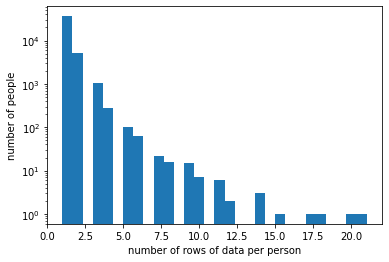

In [4]:
# Combine first and last name into one full name and check the number of rows of data per person
raw_va_sentence_df['full_name'] = raw_va_sentence_df.OffFName + ' ' + raw_va_sentence_df.OffLName
sentences_per_person = raw_va_sentence_df.groupby('full_name').count().sort_values('OffLName', ascending=False)
plt.hist(sentences_per_person.OffLName, bins = 30)
plt.ylabel('number of people')
plt.xlabel('number of rows of data per person')
plt.yscale('log')

Text(0.5, 0, 'length of sentence in months')

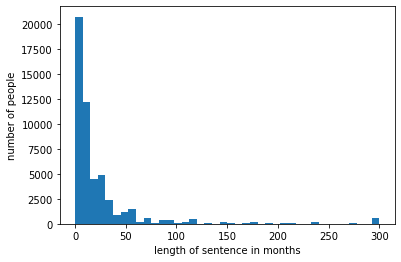

In [5]:
# Cap sentence lengths at 25 years, then plot the sentence length distribution in months.
temp = raw_va_sentence_df.copy()
temp.loc[temp.effective_sentence_months > 12 * 25, 'effective_sentence_months'] = 12 * 25
plt.hist(temp.effective_sentence_months, bins=40)
plt.ylabel('number of people')
plt.xlabel('length of sentence in months')
# plt.yscale('log')

## outflows_data
Ok, time to process our data! First up is the outflows_data table. As a reminder, outflows_data counts the number of people transitioning historically into and throughout the system. It should have one row of data per sub-group per time-step per compartment (although in our case we'll only bother with outflows for the pretrial compartment). Here is what a final outflows_data table should look like:

In [6]:
pd.DataFrame({
    'compartment': ['pretrial'] * 4,
    'outflow_to': ['probation'] * 4,
    'crime_type': ['VIOLENT'] * 2 + ['NONVIOLENT'] * 2,
    'time_step': [0,1, 0, 1],
    'total_population': [250, 233, 850, 912]
})

,compartment,outflow_to,crime_type,time_step,total_population
0,pretrial,probation,VIOLENT,0,250
1,pretrial,probation,VIOLENT,1,233
2,pretrial,probation,NONVIOLENT,0,850
3,pretrial,probation,NONVIOLENT,1,912


Okie you're up! Turn `raw_va_sentence_df` into an outflows_data table! Some important tips for this:
* Make sure you make a copy of `raw_va_sentence_df` and mess with that. If you start changing the original you won't have anything to build the other data inputs with.
* Make sure your table has exactly the right columns with the right names when you're done. df.rename() is your friend!
* `time_step` is the number of steps away from the reference date you're at. So with a reference date of 2020.0, 2021.0 would be time_step = 12. In our case, the reference_date is 2019.


In [7]:
# Step 1: Use a groupby operation to get one row per crime_type per year.

#* your code here *

outflows_data = raw_va_sentence_df.copy()
reference_year = 2019

outflows_data = outflows_data.groupby(['crime_type', 'fiscal_year']).count().reset_index().rename(columns={
    'fiscal_year': 'time_step', 
    'offense_date': 'total_population'
})

# Step 2: Change the data to be per month instead of per year. Your table should get 12 times longer when you do this.

#* your code here *

def get_time_step(fiscal_year):
    return int((fiscal_year - reference_year)*12)

outflows_data['time_step'] = outflows_data['time_step'].apply(get_time_step)
outflows_data['total_population'] = outflows_data['total_population'].apply(lambda pop: pop/12)

new_rows = []
for i, row in outflows_data.iterrows():
    for month in range(1,12):
        to_modify = row.copy()
        to_modify['time_step'] += month;
        new_rows.append(to_modify)
        
outflows_data = outflows_data.append(new_rows)
outflows_data = outflows_data.reset_index()
    
# Step 3: Add in any of the columns you're missing, drop any you don't want, and rename the ones you want to keep.
# Your column names should now match the example exactly.

#* your code here *
n = outflows_data.shape[0]
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'probation'

outflows_data = outflows_data[['compartment', 'outflow_to', 'crime_type', 'time_step', 'total_population']]
outflows_data = outflows_data.dropna()

# Step 4: Ensure the columns of our table have the correct types. In particular, make sure the `time_step` column
# has type int and `total_population` column has type float.

#* your code here *
outflows_data.dtypes

outflows_data

,compartment,outflow_to,crime_type,time_step,total_population
0,pretrial,probation,ASSAULT,-24,120.250000
1,pretrial,probation,ASSAULT,-12,117.416667
2,pretrial,probation,ASSAULT,0,117.500000
3,pretrial,probation,BURGLARY/DWELLING,-24,45.250000
4,pretrial,probation,BURGLARY/DWELLING,-12,42.333333
...,...,...,...,...,...
607,pretrial,probation,WEAPONS/FIREARMS,7,58.166667
608,pretrial,probation,WEAPONS/FIREARMS,8,58.166667
609,pretrial,probation,WEAPONS/FIREARMS,9,58.166667
610,pretrial,probation,WEAPONS/FIREARMS,10,58.166667


Woooo look at you go!! Now let's take a look at what we just made and sanity-check that it looks reasonable:

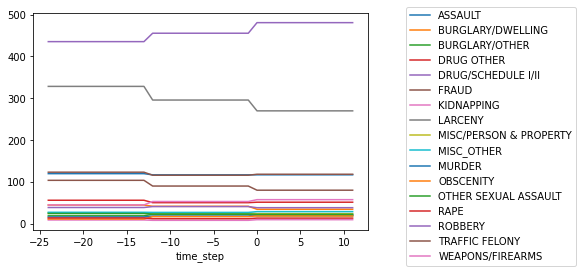

In [8]:
outflows_data.groupby(['time_step', 'crime_type']).total_population.mean().unstack('crime_type').plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))

Huh, that's kinda hard to parse. Let's try pulling out just one crime type to look at:

<AxesSubplot:xlabel='time_step'>

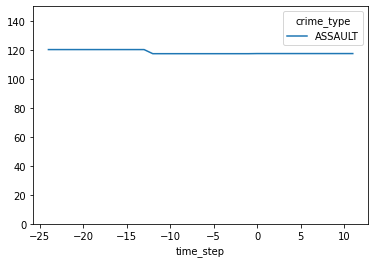

In [9]:
# Feel free to try subbing in a few different crimes to look at them one at a time
CRIME_TYPE = 'ASSAULT'
outflows_data.groupby(['time_step', 'crime_type']).total_population.mean().unstack('crime_type')[[CRIME_TYPE]].plot(ylim=[0,150])

## transitions_data
On to the transitions_data table. As a reminder, transitions_data should have one row of data per sub-group per compartment duration (aka length of stay) per full compartment (aka every one except pretrial). Here is what a final transitions table should look like:

In [10]:
pd.DataFrame({
    'compartment': ['prison'] * 3 + ['release'] * 2,
    'outflow_to': ['release'] * 5,
    'crime_type': ['VIOLENT', 'VIOLENT', 'NONVIOLENT', 'VIOLENT', 'NONVIOLENT'],
    'compartment_duration': [48,156, 30, 1, 1],
    'total_population': [0.6, 0.4, 1, 1, 1]
})

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,prison,release,VIOLENT,48,0.6
1,prison,release,VIOLENT,156,0.4
2,prison,release,NONVIOLENT,30,1.0
3,release,release,VIOLENT,1,1.0
4,release,release,NONVIOLENT,1,1.0


Okie you're up! Turn `raw_va_sentence_df` into a transitions_data table! Some important tips for this:
* Make sure you make a copy of `raw_va_sentence_df` and mess with that. If you start changing the original you won't have anything to build the other data inputs with.
* Make sure your table has exactly the right columns with the right names when you're done. df.rename() is your friend!
* The total_population column of this table only cares about the ratio of values between compartment_duration values within a given subgroup and compartment. In other words, compartment_duration : total_population = (12 : 0.2, 24: 0.4, 36: 0.4) will give the same behavior as compartment_duration : total_population = (12: 20, 24: 40, 36: 40).
* Our time steps are one month, make sure the units of your `compartment_duration` column are correct.


In [11]:
# Step 1: Use a groupby operation to get one row per crime_type per sentence length.

#* your code here *

transitions_data = raw_va_sentence_df.copy()
transitions_data = transitions_data[transitions_data.effective_sentence_months.notnull()]
transitions_data['effective_sentence_months'] = transitions_data['effective_sentence_months'].apply(round).apply(float)
transitions_data = transitions_data.groupby(['crime_type', 'effective_sentence_months']).count()

# Step 2: Add in any of the columns you're missing, drop any you don't want, and rename the ones you want to keep.
# Your column names should now match the example exactly.

#* your code here *
transitions_data = transitions_data.reset_index()
transitions_data = transitions_data.rename(columns={
    'offense_date': 'total_population', 
    'effective_sentence_months': 'compartment_duration'
})

transitions_data['total_population'] = transitions_data['total_population'].apply(float)

transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

transitions_data = transitions_data[['compartment', 'outflow_to', 'crime_type', 'compartment_duration', 'total_population']]

# Step 3: You've now finished the transitions data for the prison compartment, but we still need transitions data
# for the release compartment. For our purposes, we're gonna assume no recidivism, which means people can just go
# from release back to release (just like the example above). Create a second transitions_data table for release
# that has one trivial transition from release to itself for each subgroup.

#* your code here *

trivial_transition = transitions_data.copy()
trivial_transition['compartment'] = 'release'
trivial_transition['outflow_to'] = 'release'

# Step 4: Concatenate your two transitions tables together to get one final transitions_data

#* your code here *
transitions_data = transitions_data.append(trivial_transition)
transitions_data = transitions_data.dropna()
# Step 5: Ensure the columns of our table have the correct types. In particular, make sure the `compartment_duration`
# and `total_population` columns both have type float.

#* your code here *

transitions_data.dtypes
transitions_data

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,prison,release,ASSAULT,0.0,36.0
1,prison,release,ASSAULT,1.0,75.0
2,prison,release,ASSAULT,2.0,65.0
3,prison,release,ASSAULT,3.0,114.0
4,prison,release,ASSAULT,4.0,66.0
...,...,...,...,...,...
1657,release,release,WEAPONS/FIREARMS,78.0,1.0
1658,release,release,WEAPONS/FIREARMS,84.0,5.0
1659,release,release,WEAPONS/FIREARMS,96.0,1.0
1660,release,release,WEAPONS/FIREARMS,120.0,2.0


Killin it!! Now let's take a look at what we just made and sanity-check that it looks reasonable:

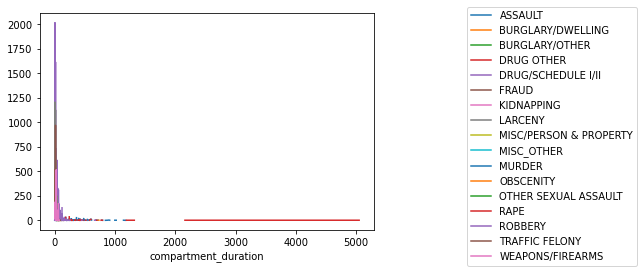

In [12]:
# Only looking at the prison compartment transitions for this check.
transitions_data[transitions_data.compartment == 'prison'].groupby(
    ['compartment_duration', 'crime_type']
).total_population.mean().unstack('crime_type').plot()
plt.legend(bbox_to_anchor=(1.8, 1.05))

Huh, that's also kinda hard to parse. Let's try pulling out just one crime type to look at:

<AxesSubplot:xlabel='compartment_duration'>

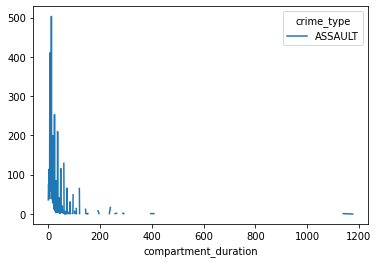

In [13]:
# Feel free to try subbing in a few different crimes to look at them one at a time
CRIME_TYPE = 'ASSAULT'
transitions_data[transitions_data.compartment == 'prison'].groupby(
    ['compartment_duration', 'crime_type']
).total_population.mean().unstack('crime_type')[[CRIME_TYPE]].plot()

## total_population_data
Last but not least: the total_population table. You'll have to go grab data for this one yourself, the data you need is on page 37 of this [report](https://vadoc.virginia.gov/media/1623/vadoc-financial-annual-mis-report-2020.pdf). `total_population_data` is the only table that doesn't need to be disaggreagted by subgroup if the data isn't there for that, so we'll just be creating a table for the total prison population and no disaggregation axis.

As a reminder, total_population_data should have one row of data per time step per full compartment (in our case just `prison`). Here is what a final populations table should look like:

In [14]:
pd.DataFrame({
    'compartment': ['prison'] * 4,
    'time_step': range(3,7),
    'total_population': [2500, 2800, 3030, 2820]
})

,compartment,time_step,total_population
0,prison,3,2500
1,prison,4,2800
2,prison,5,3030
3,prison,6,2820


Okie you're up! Turn the table from the DOC report into a `total_population_data` table! Some important tips for this:
* Make sure your table has exactly the right columns with the right names when you're done. df.rename() is your friend!
* `time_step` is the number of steps away from the reference date you're at. So with a reference date of 2020.0, 2021.0 would be time_step = 12. In our case, the reference_date is 2019.

In [15]:
# Input the data from the DOC report into a pandas DataFrame. Feel free to start with the example table
# above if that's easier. 

#* your code here *

# Time steps are based on 2019.0=Jan 2019
total_population_data = pd.DataFrame({
    'compartment': 'prison',
    'time_step': [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    'total_population': [29075, 28887, 28728, 28692, 28430, 28389, 28266, 28225, 28174, 27563, 26730, 26082]
})

total_population_data['total_population'] = total_population_data['total_population'].apply(float)

Let's double check that matches the report we copied from:

<AxesSubplot:xlabel='time_step'>

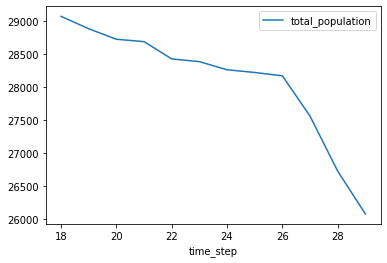

In [16]:
total_population_data.plot(x='time_step', y='total_population')

## Uploading our data
The final step in pre-processing is to upload our data to Google BigQuery. If this next cell gives you a permission error, you need to go set up your Google Cloud access–follow these steps:
1. Work through just the installation section of (this page)[https://cloud.google.com/sdk/docs/quickstart]. Make sure you log in with your Stanford email.
2. Open a terminal window and navigate to your Github repository folder. Run the following commands:
3. `gcloud auth application-default login` --> This will prompt you to log in to your google cloud account
4. `gcloud config set project recidiviz-staging`

Once you're set up, you can try the upload again.


In [17]:
# STEP 1: pick a `simulation_tag` for your simulation. "paco_parole_test" would be a reasonable example...
simulation_tag = "isaac_parole_test"


upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/test_configurations/walkthru_user_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
1it [00:07,  7.85s/it]
1it [00:09,  9.07s/it]
1it [00:06,  6.24s/it]


# Running a baseline
We're ready to build a simulation now! First step is initializing a simulation object, called a SuperSimulation. When we initialize it we pass in the filepath of our YAML configuration, so before you continue you need to go to that file, located in `recidiviz-data/recidiviz/calculator/modeling/population_projection/state/VA/2022/test_configurations`, and change the simulation_tag to match the one you chose above.

In [18]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/test_configurations/walkthru_user_inputs.yaml'
)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 4351.49rows/s]
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 2505 results


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2957/2957 [00:00<00:00, 4239.83rows/s]


transitions_data returned 2957 results


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.37rows/s]
crime_type            compartment  outflow_to
CAPITAL_MURDER        pretrial     prison        38.297872
SECOND_DEGREE_MURDER  pretrial     prison        48.936170
dtype: float64%


total_population_data returned 34 results


Now we're going to run a baseline simulation. This is an oppportunity to make sure the data we generated is valid, and to sanity-check the basic dynamics it generates. You should just be able to run the code below, but if you feel like it you can also include `release` in the `display_compartments` list to see that population evolve too.
*Make sure you pause to think about the graph this generates*. Do you believe this is actually close to reality? Is there something off, and if so what might be causing it?

In [19]:
#This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments)

KeyboardInterrupt: 

Before we move on, the other thing we can check is the timesacle analysis (ARIMA) fits that the `pretrial` compartment generated based on our outflows data. Two things to look for:
* Does this trend(s) look believable? Do we think we're capturing a reasonable guess for what could happen going forward?
* Notice any places where a fit is steep up or down and then appruptly flattens. That's a place where the model has enforced that outflows cannot deviate from the present by more than 50%. This is an arbitrary insertion, so it's usually bad news bears if we actually hit that limit.

In [ ]:
#With `by_simulation_group` set to false, you'll only see one aggregate graph. If you want to see the ARIMA fits
# for each of the subgroups separately, set that to true and run again.
spark_sim.get_arima_output_plots('baseline_middle', by_simulation_group=False)

# Running a policy scenario
I've filled out a lot of the code for you here, but once you finish out the missing pieces definitely play around with the stuff I did for you. The whole appeal of the Spark model is how easy it is to test out different policy scenarios once you get the baseline running.

Without worrying about all the details, the main thing to understand here is that a policy function transforms the transitions data of a given compartment. By applying one or multiple per compartment that is affected in the policy scneario, we can simulate the effects of the reform in question. `policy_list` is thus just a list of policy functions that gets passed into the simulation so it knows what to change in the policy scenario.

Some important pointers:
* A SparkPolicy specifies both compartment and subgroup. If you want a policy to apply to every subgroup you need one SparkPolicy per subgroup!
* Retroactivity determines whether or not a policy applies to people who are already incarcerated. Try toggling it on and off and see what happens!
* Order matters! If policy A shortens sentences by 50% and policy B shortens them by 1 year, the policy_list [A,B] will be different frmo the policy_list [B,A]

In [ ]:
# To start, let's model enabling parole by shortening the fraction of their sentence that people must serve.
# Currently, they cannot serve less than 85%. Let's suppose that this policy will bring that number down to 60%.
# Think about how you should shorten prison transitions to capture that change, then pick the appropriate parameters
# below!
LOS_REDUCTION = ?? # This parameter determines how much shorter compartment duration gets for affected individuals.
AFFECTED_FRACTION = ?? # This parameter determins the fraction of the compartment population affected by the change.
REDUCTION_TYPE = ?? #T his should either be '*' or '+'. If you make it '+', it will change compartment_duration L to
                    # L - LOS_REDUCTION. If you make it '*', it will change L to L * (1 - LOS_REDUCTION)
RETROACTIVE = ?? # This should either be True or False

#### Should not have to change things below this line for this cell ####

def apply_reinstated_parole():
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [OUTFLOW],
                       'reduction_size': [LOS_REDUCTION], 
                       'affected_fraction': [AFFECTED_FRACTION]
                   }),
                   reduction_type=REDUCTION_TYPE,
                   retroactive=RETROACTIVE)

# Note that I've created for you in this example, and picked it to apply the policy to all subgroups.
policy_list = [SparkPolicy(policy_fn=apply_reinstated_parole(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime},
                                           policy_ts=24,
                                           apply_retroactive=RETROACTIVE) 
                               for crime in transitions_data.crime_type.unique()]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

How do those results look? Does this match your expectation for the magnitude of this policy's impact?

In [ ]:
# Now let's try mixing it up a bit. Now I want you to try changing the policy so it only applies to 
# non-violent offenders. What crime_types will that be? How should you change your code to account for this?
# Hint: the only thing inside the parentheses that create the SparkPolicy object that you should need to change is
# the `sub_population`.

LOS_REDUCTION = ??
AFFECTED_FRACTION = ??
REDUCTION_TYPE = ??
RETROACTIVE = ??

def apply_reinstated_parole():
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [OUTFLOW],
                       'reduction_size': [LOS_REDUCTION], 
                       'affected_fraction': [AFFECTED_FRACTION]
                   }),
                   reduction_type=REDUCTION_TYPE,
                   retroactive=RETROACTIVE)

policy_list = [SparkPolicy(policy_fn=apply_reinstated_parole(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime},
                                           policy_ts=24,
                                           apply_retroactive=RETROACTIVE) 
                               for crime in transitions_data.crime_type.unique()]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

How do these results compare to your previous scenario? Is it more or less? By how much? Can you think of a way to validate that that result is reasonable?

# Extensions
WOOOOOO GOOOO YOUUUUUUUU!!!! That's right, you finished the notebook :)
That said, there's tons more to learn, so if you enjoyed that and want to try some more complex variations, here are some extensions:

### We collapsed jail and prison into a single compartment, but they likely behave very differently in real life. Go back to the beginning and re-do the processing after adding a jail compartment to the model architecture. 
A few hints:
1. sentence_type_code == 3 means prison, == 2 equals jail.
2. You'll need to go into the YAML configuration and add a row for jail under every row for prison
3. Bonus: how should we change the policy_list to account for this change?

### Can you implement a different policy (or the same one) using a different policy function from CompartmentTransitions.apply_reduction()?
A few hints:
1. You'll want to go into the 'transitions_table' file in the codebase and scroll to the bottom, where the policy functions are defined, to see what you can try.
2. The mechanics are all the same otherwise, so the only thing you should have to change in is the `apply_reinstated_parole` function.

### Can you add recidivism into the model?
A few hints:
1. The relevant place to make this change is in the transitions_data pre-processing, where we simply assumed everyone in `release` stays there forever. You'll want to add a probability of going back to prison.
2. You'll have to do a little digging on the DOC's website to find statistics for recidivism